In [1]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import xarray as xr
from typing import Callable, List, Union, Tuple, Dict
from pathlib import Path
import time
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import os

In [14]:
lowerBounds = [100, 1, 0, 0, 1, 0, 0, 1]
upperBounds = [1500, 15, 1, 1, 5, 1, 1, 30]

In [2]:
def load_and_preprocess_catchment_ts(runoff_path: str, catchment_path: str, catchment_name: str) -> xr.Dataset:
    """
    Optimized loading and preprocessing of time series data.
    
    Args:
        runoff_path: Path to GRDC runoff data
        catchment_path: Directory containing catchment climate data
        catchment_name: Name of the catchment
        
    Returns:
        Preprocessed xarray Dataset with aligned time series
    """
    # Convert paths to Path objects for better handling
    catchment_path = catchment_path + "/" + catchment_name.upper()
    catchment_path = Path(catchment_path)
    
    # 1. Load runoff data with optimized parameters
    runoff = xr.open_dataset(
        runoff_path,
        chunks={'time': 'auto'},  # Enable chunking for better memory management
        cache=True              # Cache the data for faster repeated access
    ).load()
    
    # 2. Immediately select time period and station
    runoff = runoff.sel(
        time=slice('2000-03-01', '2022-12-19')
    )

    catchment_id = runoff["station_name"].values == catchment_name.upper()
    catchment_index = np.where(catchment_id)[0][0]

    # Select only the runoff timeseries
    runoff = runoff["runoff_mean"].isel(id=catchment_index)
    
    # 3. Use dictionary comprehension for cleaner climate data loading
    climate_vars = {
        'temperature': 't2m',
        'precipitation': 'precipitation',
        'radiation': 'nr',
        'ndvi': 'ndvi'
    }
    
    # 4. Parallel loading of climate data
    climate_ds = xr.open_mfdataset(
        [catchment_path/f'{var}.nc' for var in climate_vars],
        parallel=True,  # Enable parallel loading
        combine='by_coords',
        chunks={'time': 'auto'},
        cache=True
    ).load()
    
    # 5. Create output dataset with aligned data
    data = xr.Dataset({
        'temperature': climate_ds[climate_vars['temperature']],
        'precipitation': climate_ds[climate_vars['precipitation']],
        'radiation': climate_ds[climate_vars['radiation']],
        'ndvi': climate_ds[climate_vars['ndvi']],
        'observed': runoff.broadcast_like(climate_ds[climate_vars['radiation']])
    })
    
    # 6. Ensure consistent time alignment
    data = data.sel(time=slice('2001-01-01', '2021-12-31'))
    
    # 7. Convert to float32 to save memory (if precision is sufficient)
    #for var in data.data_vars:
    #    data[var] = data[var].astype(np.float32)
    
    return data

In [65]:
data = load_and_preprocess_catchment_ts(
    runoff_path="data/catchments/GRDC-Daily.nc",
    catchment_path="data/catchment_timeseries",
    catchment_name="BENTFELD"
)
data

<xarray.Dataset> Size: 6MB
Dimensions:        (time: 7670, x: 5, y: 5)
Coordinates:
  * time           (time) datetime64[ns] 61kB 2001-01-01 ... 2021-12-31
  * x              (x) float64 40B 8.55 8.65 8.75 8.85 8.95
  * y              (y) float64 40B 51.85 51.75 51.65 51.55 51.45
    spatial_ref    int64 8B 0
    id             int32 4B 6335082
Data variables:
    temperature    (time, y, x) float32 767kB nan nan nan ... 283.9 nan nan
    precipitation  (time, y, x) float64 2MB nan nan nan ... 0.0009844 nan nan
    radiation      (time, y, x) float64 2MB nan nan nan ... -2.123e+04 nan nan
    ndvi           (time, y, x) float64 2MB nan nan nan 0.0 ... 0.04894 nan nan
    observed       (time, y, x) float32 767kB 5.354 5.354 5.354 ... nan nan nan

In [4]:
@njit(fastmath=True)
def time_evolution_numba(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
    #Initialize 
    length = len(temp)
    runoff_out = np.full(length, np.nan)
    evapo_out = np.full(length, np.nan)
    soil_mois_out = np.full(length, np.nan)
    snow_out = np.full(length, np.nan)

    # Transformations / Calculations for Setup
    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    w = 0.9 * c_s
    snow = 0

    # --- calc_et_weight function ---
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    normalized_temp = (temp - temp.min()) / (temp.max() - temp.min())
    normalized_ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    et_weight = temp_w * normalized_temp + ndvi_w * normalized_ndvi
    beta_weighted = beta * et_weight

    for t in range(1, length):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_t = beta_weighted[t-1]

        # ---- snow_function ----
        is_melting = temp_t > 273.15
        has_snow = snow >= 0.001

        if not is_melting:
            snow += prec_t
            water = 0.0
        elif is_melting and has_snow:
            melt = c_m * (temp_t - 273.15)
            melt = min(melt, snow)
            snow -= melt
            water = melt + prec_t
        else:
            water = prec_t

        runoff = (water + iota) * (w / c_s) ** alpha
        evap = beta_t * (w / c_s) ** gamma * rad_t

        w += (water - runoff - evap)
        w = np.maximum(w, 0.0)

        # Store results
        runoff_out[t] = runoff
        evapo_out[t] = evap
        soil_mois_out[t] = w
        snow_out[t] = snow

    return runoff_out, evapo_out, soil_mois_out, snow_out

In [5]:
params = [840, 8, 0.8, 0.5, 2, 10, 0.75, 0.5]

c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w = params

dataMean = xr.Dataset()
dataMean['temperature'] = data["temperature"].mean(dim=("x", "y"))
dataMean['precipitation'] = data["precipitation"].mean(dim=("x", "y"))
dataMean['radiation'] = data["radiation"].mean(dim=("x", "y"))
dataMean['ndvi'] = data["ndvi"].mean(dim=("x", "y"))
dataMean['observed'] = data["observed"].sum(dim=("x", "y"))
temp = dataMean['temperature'].values
rad = dataMean['radiation'].values
prec = dataMean['precipitation'].values
ndvi = dataMean['ndvi'].values
observed = dataMean['observed'].values

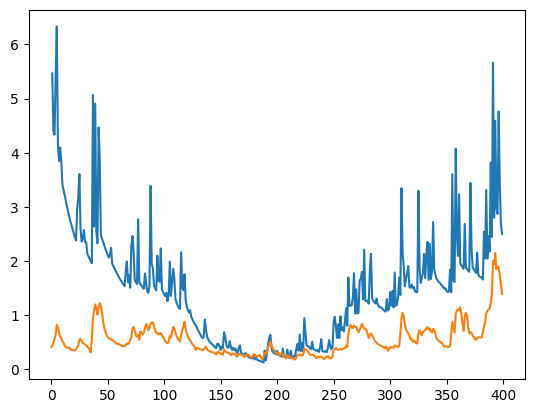

In [6]:
simulated,_,_,_ = time_evolution_numba(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w)
normalized = (data["observed"]*86400/(1018*1000))
plt.plot(simulated[:400])
plt.plot(normalized[:400].mean(dim=("x", "y")))

In [7]:
def split_data(data, splitPerc):
        leng = data.sizes["time"]
        maxYear = leng/365
        sample = np.random.randint(0, maxYear, int(maxYear*splitPerc))
        mask = np.zeros(leng, dtype=bool)
        for s in sample:
            mask[s*365:(s+1)*365] = True
        train = data.isel(time=np.where(~mask)[0])
        test = data.isel(time=np.where(mask)[0])

        return train, test

In [8]:
@njit
def compute_correlation_numba(observed: np.ndarray, simulated: np.ndarray) -> np.float32:
    """Numba-optimized Pearson correlation calculation."""
    # Create mask for valid observations
    mask = (~np.isnan(observed)) & (~np.isnan(simulated))
    valid_count = np.sum(mask)
    
    if valid_count < 2:
        return -np.inf  # Return negative infinity for invalid cases
    
    # Extract valid values
    x = observed[mask]
    y = simulated[mask]
    
    # Compute means
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Center the data
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    # Compute correlation components
    numerator = np.dot(x_centered, y_centered)
    denominator = np.sqrt(np.dot(x_centered, x_centered) * np.dot(y_centered, y_centered))
    
    return numerator / denominator if denominator > 0 else 0.0

def create_evaluator(temp, rad, prec, ndvi, observed):
    """Factory function with consistent types."""
    # Convert inputs to float32 and ensure contiguous
    temp = np.ascontiguousarray(temp, dtype=np.float32)
    rad = np.ascontiguousarray(rad, dtype=np.float32)
    prec = np.ascontiguousarray(prec, dtype=np.float32)
    ndvi = np.ascontiguousarray(ndvi, dtype=np.float32)
    observed = np.ascontiguousarray(observed, dtype=np.float32)

    def evaluate_individual(params):
        """Type-consistent evaluation."""
        c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w = params
        
        simulated = time_evolution_numba(
            temp=temp,
            rad=rad,
            prec=prec,
            ndvi=ndvi,
            c_s=c_s,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            c_m=c_m,
            iota=iota,
            temp_w=temp_w,
            ndvi_w=ndvi_w
        )[0]

        return compute_correlation_numba(observed, simulated)    
    return evaluate_individual

In [10]:
trainVal, test = split_data(dataMean, 0.8)

In [48]:
start_time = time.time()
evaluator = create_evaluator(
    temp=trainVal["temperature"],
    rad=trainVal["radiation"],
    prec=trainVal["precipitation"],
    ndvi=trainVal["ndvi"],
    observed=trainVal["observed"]
)

# Test evaluation
params = np.array([840, 8, 0.8, 0.5, 2, 10, 0.75, 0.5], dtype=np.float32)
fitness = evaluator(params)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print(fitness)

calculations completed in 0.00098 seconds.
0.8008672898498175


In [46]:
import numpy as np
from typing import Union, List, Tuple, Callable

def initialize_population(
    pop_size: int,
    genome_length: int,
    lower_bounds: List[float],
    upper_bounds: List[float],
    quantization_steps: int = 20
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Initialize a population uniformly within given bounds.
    
    Args:
        pop_size: Number of individuals in population
        genome_length: Length of each genome
        lower_bounds: List of lower bounds for each gene
        upper_bounds: List of upper bounds for each gene
        quantization_steps: Number of discrete steps for genome space
        
    Returns:
        Tuple of (population array, genome_space array)
    """
    # Convert bounds to numpy arrays (faster than checking types)
    lower = np.asarray(lower_bounds, dtype=np.float64)
    upper = np.asarray(upper_bounds, dtype=np.float64)
    
    # Generate population in one vectorized operation
    population = np.random.uniform(
        low=lower,
        high=upper,
        size=(pop_size, genome_length)
    )
    
    # Create genome space for quantization
    # Transpose to get shape (genome_length, quantization_steps)
    genome_space = np.linspace(lower, upper, quantization_steps).T
    
    return population, genome_space

def evaluate_fitness(
    population: np.ndarray,
    evaluator: Callable[[np.ndarray], float]
) -> np.ndarray:
    """
    Evaluate fitness for each individual in the population.
    Vectorized implementation if fitness_func supports it.
    """
    fitnesses = np.empty(len(population), dtype=np.float32)
    for i in prange(len(population)):
        fitnesses[i] = evaluator(population[i])
    return fitnesses

def select_survivors(
    population: np.ndarray,
    fitnesses: np.ndarray,
    num_parents: int
) -> np.ndarray:
    """
    Roulette wheel (fitness-proportionate) selection.
    Vectorized implementation.
    """
    probs = fitnesses / np.sum(fitnesses)
    indices = np.random.choice(len(population), size=num_parents, replace=True, p=probs)
    return population[indices]

def pop_crossover(
    pop: np.ndarray,
    crossover_rate: float = 0.8
) -> np.ndarray:
    """
    Vectorized single-point crossover for entire population.
    """
    pop_size, genome_length = pop.shape
    if genome_length < 2:
        return pop.copy()
    
    # Create mask for which individuals will crossover
    crossover_mask = np.random.rand(pop_size // 2) < crossover_rate
    num_crossovers = np.sum(crossover_mask)
    
    if num_crossovers == 0:
        return pop
    
    # Select parents and prepare children
    parents1 = pop[:num_crossovers]
    parents2 = pop[num_crossovers:2*num_crossovers]
    
    # Vectorized crossover
    crossover_points = np.random.randint(1, genome_length, size=num_crossovers)
    mask = np.arange(genome_length) < crossover_points[:, None]
    
    children1 = np.where(mask, parents1, parents2)
    children2 = np.where(mask, parents2, parents1)
    
    # Put children back in population
    pop[:num_crossovers] = children1
    pop[num_crossovers:2*num_crossovers] = children2
    
    return pop

def pop_mutate(
    pop: np.ndarray,
    genome_space: np.ndarray,
    mutation_rate: float,
    mutation_scale: float = 0.1
) -> np.ndarray:
    """
    Vectorized mutation with optional quantization.
    """
    pop_size, genome_length = pop.shape
    num_mutations = int(mutation_rate * pop_size * genome_length)
    
    if num_mutations == 0:
        return pop
    
    # Create random mutation indices
    mut_indices = np.random.choice(pop_size * genome_length, size=num_mutations, replace=False)
    rows, cols = np.unravel_index(mut_indices, pop.shape)
    
    # Apply mutations
    if genome_space is not None:
        # Quantized mutation
        which_steps = np.random.randint(0, genome_space.shape[1], size=num_mutations)
        pop[rows, cols] = genome_space[cols, which_steps]
    else:
        # Gaussian mutation
        lower = genome_space[:, 0] if genome_space is not None else np.min(pop, axis=0)
        upper = genome_space[:, -1] if genome_space is not None else np.max(pop, axis=0)
        ranges = upper - lower
        noise = np.random.normal(scale=mutation_scale * ranges[cols], size=num_mutations)
        pop[rows, cols] = np.clip(pop[rows, cols] + noise, lower[cols], upper[cols])
    
    return pop

def select_survivors_elitism(
    combined_pop: np.ndarray,
    combined_fit: np.ndarray,
    pop_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    (mu + lambda) survivor selection: keep best individuals.
    Vectorized implementation.
    """
    idx = np.argsort(combined_fit)[-pop_size:]
    return combined_pop[idx], combined_fit[idx]

def run_ga(
    fitness_func: Callable[[np.ndarray], float],
    genome_length: int,
    lower_bounds: Union[float, List[float]],
    upper_bounds: Union[float, List[float]],
    pop_size: int = 50,
    num_generations: int = 100,
    num_parents: int = 30,
    crossover_rate: float = 0.8,
    mutation_rate: float = 0.1,
    mutation_scale: float = 0.1,
    use_quantization: bool = False,
    seed: int = None
) -> Tuple[np.ndarray, List[float], List[float]]:
    """
    Optimized genetic algorithm with vectorized operations.
    Returns (best_individual, best_fitness_history, avg_fitness_history).
    """
    if seed is not None:
        np.random.seed(seed)

    # Initialize population
    quantization_steps = 20 if use_quantization else 0
    population, genome_space = initialize_population(
        pop_size, genome_length, lower_bounds, upper_bounds, quantization_steps
    )
    fitnesses = evaluate_fitness(population, fitness_func)
    best_hist = []
    avg_hist = []

    for gen in range(num_generations):
        # Record stats
        best_hist.append(np.max(fitnesses))
        avg_hist.append(np.mean(fitnesses))

        # Selection
        parents = select_survivors(population, fitnesses, num_parents)
        
        # Create offspring by copying parents
        offspring = parents.copy()
        
        # Crossover
        offspring = pop_crossover(offspring, crossover_rate)
        
        # Mutation
        offspring = pop_mutate(
            offspring, 
            genome_space if use_quantization else None,
            mutation_rate,
            mutation_scale
        )
        
        # Evaluate offspring
        offspring_fit = evaluate_fitness(offspring, fitness_func)
        
        # Survivor selection (elitism)
        combined_pop = np.vstack((population, offspring))
        combined_fit = np.concatenate((fitnesses, offspring_fit))
        population, fitnesses = select_survivors_elitism(combined_pop, combined_fit, pop_size)

    # Final stats
    best_hist.append(np.max(fitnesses))
    avg_hist.append(np.mean(fitnesses))
    best_idx = np.argmax(fitnesses)
    best_individual = population[best_idx]

    return best_individual, best_hist, avg_hist

In [47]:
start_time = time.time()
pop,_ = initialize_population(50, 8, lowerBounds, upperBounds)
fitnesses = evaluate_fitness(pop, evaluator)
print(len(select_survivors(pop, fitnesses, 30)))
print(f"calculations completed in {duration:.5f} seconds.")

30
calculations completed in 0.00100 seconds.


## Long Genome GA for Gridcells

In [16]:
@njit
def compute_correlation_numba(observed: np.ndarray, simulated: np.ndarray) -> np.float32:
    """Numba-optimized Pearson correlation calculation."""
    # Create mask for valid observations
    mask = (~np.isnan(observed)) & (~np.isnan(simulated))
    valid_count = np.sum(mask)
    
    if valid_count < 2:
        return -np.inf  # Return negative infinity for invalid cases
    
    # Extract valid values
    x = observed[mask]
    y = simulated[mask]
    
    # Compute means
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Center the data
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    # Compute correlation components
    numerator = np.dot(x_centered, y_centered)
    denominator = np.sqrt(np.dot(x_centered, x_centered) * np.dot(y_centered, y_centered))
    
    return numerator / denominator if denominator > 0 else 0.0

def create_evaluator_grid(temp, rad, prec, ndvi, observed):
    """
    Creates an evaluator function that safely evaluates the model
    across a 2D grid with NaN-masked pixels.
    """
    temp = temp.astype("float32")
    rad = rad.astype("float32")
    prec = prec.astype("float32")
    ndvi = ndvi.astype("float32")
    observed = observed.astype("float32")

    n_params = 8
    x_dim = temp.sizes["x"]
    y_dim = temp.sizes["y"]

    def evaluate_individual(genome):
        # Reshape flat genome to (param, x, y)
        genome_array = np.asarray(genome, dtype=np.float32).reshape((x_dim, y_dim, n_params)).transpose(2, 0, 1)

        # Store parameters in Dataset
        param_ds = xr.Dataset({
            "c_s":     (("x", "y"), genome_array[0]),
            "alpha":   (("x", "y"), genome_array[1]),
            "beta":    (("x", "y"), genome_array[2]),
            "gamma":   (("x", "y"), genome_array[3]),
            "c_m":     (("x", "y"), genome_array[4]),
            "iota":    (("x", "y"), genome_array[5]),
            "temp_w":  (("x", "y"), genome_array[6]),
            "ndvi_w":  (("x", "y"), genome_array[7]),
        })

        # Define the safe simulation function
        def simulate_and_score(temp, rad, prec, ndvi, obs,
                       c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
            if (
                np.all(np.isnan(temp)) or
                np.all(np.isnan(rad)) or
                np.all(np.isnan(prec)) or
                np.all(np.isnan(ndvi)) or
                np.all(np.isnan(obs))
            ):
                return np.nan  # skip completely invalid pixel

            sim = time_evolution_numba(
                temp=temp,
                rad=rad,
                prec=prec,
                ndvi=ndvi,
                c_s=c_s,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                c_m=c_m,
                iota=iota,
                temp_w=temp_w,
                ndvi_w=ndvi_w
            )[0]

            return compute_correlation_numba(obs, sim)

        # Apply pixel-wise evaluation
        score = xr.apply_ufunc(
            simulate_and_score,
            temp, rad, prec, ndvi, observed,
            param_ds["c_s"], param_ds["alpha"], param_ds["beta"],
            param_ds["gamma"], param_ds["c_m"], param_ds["iota"],
            param_ds["temp_w"], param_ds["ndvi_w"],
            input_core_dims=[["time"]] * 5 + [[]]*8,
            output_core_dims=[[]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[np.float32]
        )

        # Only average over valid grid cells (non-NaN scores)
        valid_score = score.where(~np.isnan(score))
        return float(valid_score.mean(skipna=True))

    return evaluate_individual

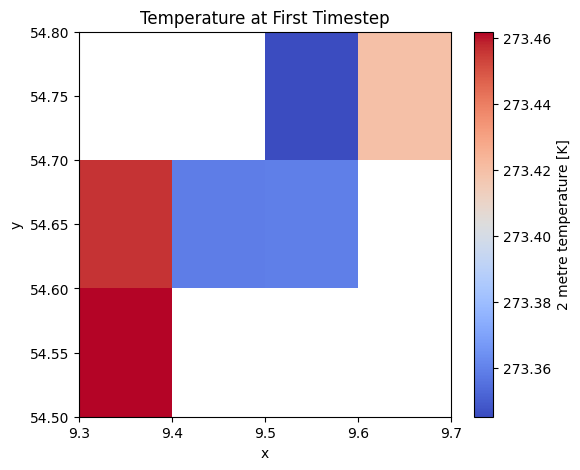

In [17]:
temp0 = data["temperature"].isel(time=0)

# Plot
plt.figure(figsize=(6, 5))
temp0.plot(cmap="coolwarm")  # You can change the colormap if you like
plt.title("Temperature at First Timestep")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [121]:
mask = ~np.isnan(data["temperature"].isel(time=0))  # shape: (y, x)
n_valid_pixels = int(mask.sum())
n_valid_pixels
mask

<xarray.DataArray 'temperature' (y: 3, x: 4)> Size: 12B
array([[False, False,  True,  True],
       [ True,  True,  True, False],
       [ True, False, False, False]])
Coordinates:
    time         datetime64[ns] 8B 2001-01-01
  * x            (x) float64 32B 9.35 9.45 9.55 9.65
  * y            (y) float64 24B 54.75 54.65 54.55
    spatial_ref  int64 8B 0
    id           int32 4B 6334800
Attributes:
    long_name:  2 metre temperature
    units:      K

In [22]:
start_time = time.time()
evaluator = create_evaluator_grid(
    temp=data["temperature"],
    rad=data["radiation"],
    prec=data["precipitation"],
    ndvi=data["ndvi"],
    observed=data["observed"]
)

# Test evaluation
params = np.array([840, 8, 0.8, 0.5, 2, 10, 0.75, 0.5]*12, dtype=np.float32)
fitness = evaluator(params)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print(fitness)

calculations completed in 0.00797 seconds.
0.8524932265281677


In [19]:
import numpy as np
from typing import Union, List, Tuple, Callable

def initialize_population(
    pop_size: int,
    genome_length: int,
    lower_bounds: List[float],
    upper_bounds: List[float],
    quantization_steps: int = 20
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Initialize a population uniformly within given bounds.
    
    Args:
        pop_size: Number of individuals in population
        genome_length: Length of each genome
        lower_bounds: List of lower bounds for each gene
        upper_bounds: List of upper bounds for each gene
        quantization_steps: Number of discrete steps for genome space
        
    Returns:
        Tuple of (population array, genome_space array)
    """
    # Convert bounds to numpy arrays (faster than checking types)
    lower = np.asarray(lower_bounds, dtype=np.float64)
    upper = np.asarray(upper_bounds, dtype=np.float64)
    
    # Generate population in one vectorized operation
    population = np.random.uniform(
        low=lower,
        high=upper,
        size=(pop_size, genome_length)
    )
    
    # Create genome space for quantization
    # Transpose to get shape (genome_length, quantization_steps)
    genome_space = np.linspace(lower, upper, quantization_steps).T
    
    return population, genome_space

def evaluate_fitness(
    population: np.ndarray,
    evaluator: Callable[[np.ndarray], float]
) -> np.ndarray:
    """
    Evaluate fitness for each individual in the population.
    Vectorized implementation if fitness_func supports it.
    """
    fitnesses = np.empty(len(population), dtype=np.float32)
    for i in prange(len(population)):
        fitnesses[i] = evaluator(population[i])
    return fitnesses

def select_survivors(
    population: np.ndarray,
    fitnesses: np.ndarray,
    num_parents: int
) -> np.ndarray:
    """
    Roulette wheel (fitness-proportionate) selection.
    Vectorized implementation.
    """
    probs = fitnesses / np.sum(fitnesses)
    indices = np.random.choice(len(population), size=num_parents, replace=True, p=probs)
    return population[indices]

def pop_crossover(
    pop: np.ndarray,
    crossover_rate: float = 0.8
) -> np.ndarray:
    """
    Vectorized single-point crossover for entire population.
    """
    pop_size, genome_length = pop.shape
    if genome_length < 2:
        return pop.copy()
    
    # Create mask for which individuals will crossover
    crossover_mask = np.random.rand(pop_size // 2) < crossover_rate
    num_crossovers = np.sum(crossover_mask)
    
    if num_crossovers == 0:
        return pop
    
    # Select parents and prepare children
    parents1 = pop[:num_crossovers]
    parents2 = pop[num_crossovers:2*num_crossovers]
    
    # Vectorized crossover
    crossover_points = np.random.randint(1, genome_length, size=num_crossovers)
    mask = np.arange(genome_length) < crossover_points[:, None]
    
    children1 = np.where(mask, parents1, parents2)
    children2 = np.where(mask, parents2, parents1)
    
    # Put children back in population
    pop[:num_crossovers] = children1
    pop[num_crossovers:2*num_crossovers] = children2
    
    return pop

def pop_mutate(
    pop: np.ndarray,
    genome_space: np.ndarray,
    mutation_rate: float,
    mutation_scale: float = 0.1
) -> np.ndarray:
    """
    Vectorized mutation with optional quantization.
    """
    pop_size, genome_length = pop.shape
    num_mutations = int(mutation_rate * pop_size * genome_length)
    
    if num_mutations == 0:
        return pop
    
    # Create random mutation indices
    mut_indices = np.random.choice(pop_size * genome_length, size=num_mutations, replace=False)
    rows, cols = np.unravel_index(mut_indices, pop.shape)
    
    # Apply mutations
    if genome_space is not None:
        # Quantized mutation
        which_steps = np.random.randint(0, genome_space.shape[1], size=num_mutations)
        pop[rows, cols] = genome_space[cols, which_steps]
    else:
        # Gaussian mutation
        lower = genome_space[:, 0] if genome_space is not None else np.min(pop, axis=0)
        upper = genome_space[:, -1] if genome_space is not None else np.max(pop, axis=0)
        ranges = upper - lower
        noise = np.random.normal(scale=mutation_scale * ranges[cols], size=num_mutations)
        pop[rows, cols] = np.clip(pop[rows, cols] + noise, lower[cols], upper[cols])
    
    return pop

def select_survivors_elitism(
    combined_pop: np.ndarray,
    combined_fit: np.ndarray,
    pop_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    (mu + lambda) survivor selection: keep best individuals.
    Vectorized implementation.
    """
    idx = np.argsort(combined_fit)[-pop_size:]
    return combined_pop[idx], combined_fit[idx]

def run_ga(
    fitness_func: Callable[[np.ndarray], float],
    genome_length: int,
    lower_bounds: Union[float, List[float]],
    upper_bounds: Union[float, List[float]],
    pop_size: int = 50,
    num_generations: int = 100,
    num_parents: int = 30,
    crossover_rate: float = 0.8,
    mutation_rate: float = 0.1,
    mutation_scale: float = 0.1,
    use_quantization: bool = False,
    seed: int = None
) -> Tuple[np.ndarray, List[float], List[float]]:
    """
    Optimized genetic algorithm with vectorized operations.
    Returns (best_individual, best_fitness_history, avg_fitness_history).
    """
    if seed is not None:
        np.random.seed(seed)

    # Initialize population
    quantization_steps = 20 if use_quantization else 0
    population, genome_space = initialize_population(
        pop_size, genome_length, lower_bounds, upper_bounds, quantization_steps
    )
    fitnesses = evaluate_fitness(population, fitness_func)
    best_hist = []
    avg_hist = []

    for gen in range(num_generations):
        # Record stats
        best_hist.append(np.max(fitnesses))
        avg_hist.append(np.mean(fitnesses))

        # Selection
        parents = select_survivors(population, fitnesses, num_parents)
        
        # Create offspring by copying parents
        offspring = parents.copy()
        
        # Crossover
        offspring = pop_crossover(offspring, crossover_rate)
        
        # Mutation
        offspring = pop_mutate(
            offspring, 
            genome_space if use_quantization else None,
            mutation_rate,
            mutation_scale
        )
        
        # Evaluate offspring
        offspring_fit = evaluate_fitness(offspring, fitness_func)
        
        # Survivor selection (elitism)
        combined_pop = np.vstack((population, offspring))
        combined_fit = np.concatenate((fitnesses, offspring_fit))
        population, fitnesses = select_survivors_elitism(combined_pop, combined_fit, pop_size)

    # Final stats
    best_hist.append(np.max(fitnesses))
    avg_hist.append(np.mean(fitnesses))
    best_idx = np.argmax(fitnesses)
    best_individual = population[best_idx]

    return best_individual, best_hist, avg_hist

In [11]:
data

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 7670, x: 4, y: 3)
Coordinates:
  * time           (time) datetime64[ns] 61kB 2001-01-01 ... 2021-12-31
  * x              (x) float64 32B 9.35 9.45 9.55 9.65
  * y              (y) float64 24B 54.75 54.65 54.55
    spatial_ref    int64 8B 0
    id             int32 4B 6334800
Data variables:
    temperature    (time, y, x) float32 368kB nan nan 273.3 ... nan nan nan
    precipitation  (time, y, x) float64 736kB nan nan 0.002625 ... nan nan nan
    radiation      (time, y, x) float64 736kB nan nan -5.504e+05 ... nan nan nan
    ndvi           (time, y, x) float64 736kB nan nan 0.6441 ... nan nan nan
    observed       (time, y, x) float32 368kB 4.812 4.812 4.812 ... 7.588 7.588

In [45]:
data.sizes['x']

4

In [44]:
lowerBounds = [100, 1, 0, 0, 1, 1, 0, 0]
upperBounds = [1500, 15, 1, 1, 5, 30, 1, 1]
#n_size = data.sizes['x'] * data.sizes['y']
n_size = 12
start_time = time.time()
best, best_hist, avg_hist = run_ga(
        fitness_func=evaluator,
        genome_length=8*n_size,
        lower_bounds=lowerBounds*n_size,
        upper_bounds=upperBounds*n_size,
        pop_size=100,
        num_generations=100,
        num_parents=40,
        crossover_rate=0.9,
        mutation_rate=0.05,
        mutation_scale=0.2,
        seed=42
    )

duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print('Best individual:', best)
print('Best fitness:', best_hist[-1])

ValueError: too many values to unpack (expected 8)

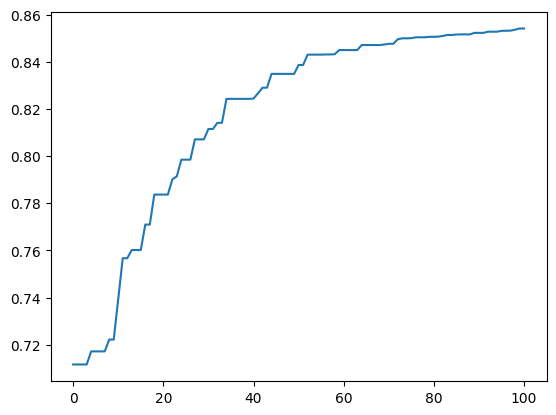

In [109]:
plt.plot(best_hist)

In [113]:
len(best)/8

25.0

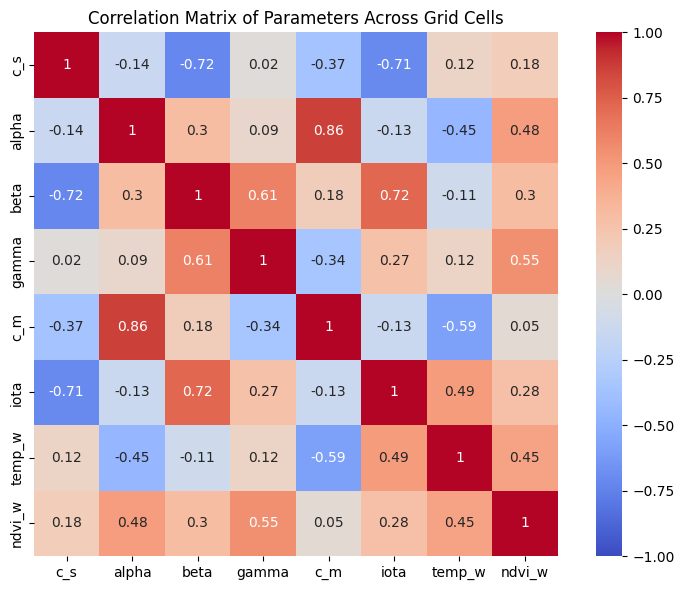

In [126]:
import seaborn as sns
n_x, n_y = 3, 4
n_params = 8
param_names = ['c_s', 'alpha', 'beta', 'gamma', 'c_m', 'iota', 'temp_w', 'ndvi_w']

# Reshape to (5, 5, 8)
param_cube = best.reshape(n_x, n_y, n_params)

# Apply mask to get only valid grid cells
valid_mask = mask.values
params_valid = param_cube[valid_mask]  # Shape: (n_valid_pixels, 8)
df_params = pd.DataFrame(params_valid, columns=param_names)

# Compute correlation matrix
corr_matrix = df_params.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix of Parameters Across Grid Cells")
plt.tight_layout()
plt.show()

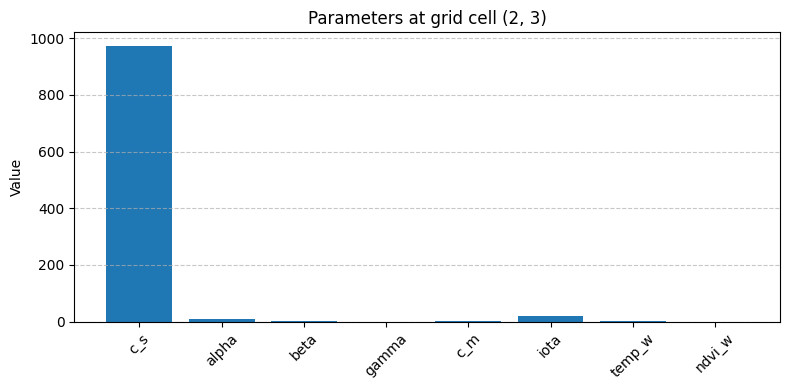

In [117]:
import matplotlib.pyplot as plt

param_names = ['c_s', 'alpha', 'beta', 'gamma', 'c_m', 'iota', 'temp_w', 'ndvi_w']

plt.figure(figsize=(8, 4))
plt.bar(param_names, params_pixel)
plt.title(f"Parameters at grid cell ({x}, {y})")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Bootstrapping

In [49]:
lowerBounds = [100, 1, 0, 0, 1, 1, 0, 0]
upperBounds = [1500, 15, 1, 1, 5, 30, 1, 1]

start_time = time.time()
best, best_hist, avg_hist = run_ga(
        fitness_func=evaluator,
        genome_length=8,
        lower_bounds=lowerBounds,
        upper_bounds=upperBounds,
        pop_size=100,
        num_generations=20,
        num_parents=40,
        crossover_rate=0.9,
        mutation_rate=0.05,
        mutation_scale=0.2,
        seed=42
    )

duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print('Best individual:', best)
print('Best fitness:', best_hist[-1])

calculations completed in 0.14584 seconds.
Best individual: [4.25097773e+02 1.41223443e+01 6.35093651e-01 4.53040098e-02
 4.25119827e+00 1.91499376e+01 8.92558998e-01 5.39342242e-01]
Best fitness: 0.90944254


In [50]:
start_time = time.time()
evaluatorTest = create_evaluator(
    temp=test["temperature"],
    rad=test["radiation"],
    prec=test["precipitation"],
    ndvi=test["ndvi"],
    observed=test["observed"]
)

# Test evaluation
fitnessTest = evaluatorTest(best)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print(fitnessTest)

calculations completed in 0.00114 seconds.
0.8809077784689261


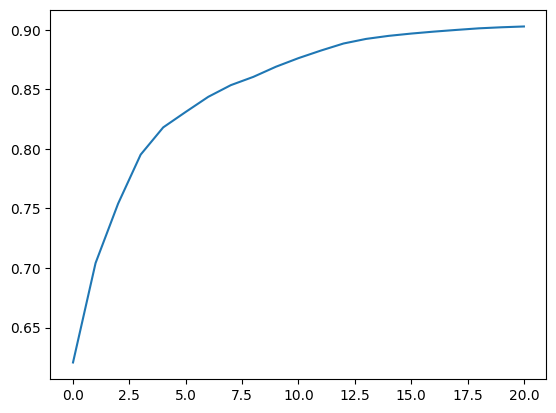

In [51]:
plt.plot(avg_hist)

In [52]:
@njit
def generate_block_indices(n: int, block_size: int, n_blocks: int) -> np.ndarray:
    """Efficient block sampling with Numba."""
    indices = np.empty(n, dtype=np.int32)
    for i in range(n_blocks):
        start = np.random.randint(0, n - block_size + 1)
        end = start + block_size
        if i == n_blocks - 1:  # Last block may be partial
            end = min(start + block_size, n)
        indices[i*block_size : (i+1)*block_size] = np.arange(start, end)
    return indices[:n]  # Trim to original length

In [53]:
def process_bootstrap_sample(dataset: xr.Dataset, sampled_years: np.ndarray) -> Dict[str, np.ndarray]:
    """Process a single bootstrap sample (to be parallelized)."""
    sample_data = {}
    for var in dataset.data_vars:
        chunks = []
        for year in sampled_years:
            year_data = dataset[var].sel(time=dataset.time.dt.year == year)
            chunks.append(year_data)
        sample_data[var] = xr.concat(chunks, dim='time').values
    return sample_data

def parallel_year_bootstrap(dataset: xr.Dataset, 
                          n_samples: int = 10, 
                          n_jobs: int = -1) -> List[Dict[str, np.ndarray]]:
    """
    Parallel year-based block bootstrap.
    
    Args:
        dataset: xarray Dataset containing all variables
        n_samples: Number of bootstrap samples
        n_jobs: Number of parallel jobs (-1 for all cores)
        
    Returns:
        List of bootstrap samples
    """
    years = pd.to_datetime(dataset.time.values).year
    unique_years = np.unique(years)
    n_years = len(unique_years)
    
    # Generate all year samples upfront
    year_samples = [np.random.choice(unique_years, size=n_years, replace=True) 
                   for _ in range(n_samples)]
    
    # Process in parallel with progress bar
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_bootstrap_sample)(dataset, years) 
        for years in tqdm(year_samples, desc="Bootstrapping"))
    
    return results

In [30]:
start_time = time.time()
bs = parallel_year_bootstrap(dataMean, n_samples=1000)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

Bootstrapping: 100%|██████████| 1000/1000 [00:20<00:00, 49.80it/s]


calculations completed in 20.78841 seconds.


In [31]:
data

<xarray.Dataset> Size: 2MB
Dimensions:        (time: 8329, x: 2, y: 3)
Coordinates:
  * time           (time) datetime64[ns] 67kB 2000-03-01 ... 2022-12-19
  * x              (x) float64 16B 9.95 10.05
  * y              (y) float64 24B 48.15 48.05 47.95
    spatial_ref    int64 8B 0
    id             int32 4B 6342105
Data variables:
    temperature    (time, y, x) float32 200kB nan 277.3 nan ... 273.8 273.8
    precipitation  (time, y, x) float64 400kB nan 0.008063 ... 0.0001016
    radiation      (time, y, x) float64 400kB nan 2.834e+06 ... -8.796e+04
    ndvi           (time, y, x) float64 400kB nan 0.6058 nan ... 0.7513 0.7696
    observed       (time, y, x) float32 200kB 6.418 6.418 6.418 ... 2.193 2.193

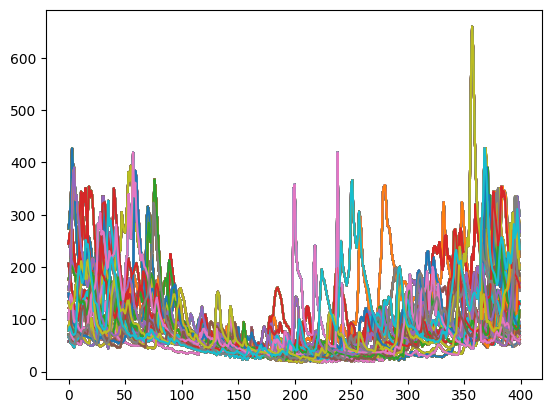

In [32]:
for b in bs:
    plt.plot(b["observed"][:400])

In [60]:
def parallel_ga_wrapper(sample: Dict[str, np.ndarray]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Wrapper function for parallel GA execution."""
    evaluator = create_evaluator(
        temp=sample['temperature'],
        rad=sample['radiation'],
        prec=sample['precipitation'],
        ndvi=sample['ndvi'],
        observed=sample['observed']
    )
    #n_size = sample.sizes['x']*sample.sizes['y']
    n_size = 12
    return run_ga(
                fitness_func=evaluator,
                genome_length=8,
                lower_bounds=lowerBounds,
                upper_bounds=upperBounds,
                pop_size=100,
                num_generations=20,
                num_parents=40,
                crossover_rate=0.9,
                mutation_rate=0.05,
                mutation_scale=0.2,
                seed=42
            )

def run_parallel_ga_bootstrap(
    dataset: xr.Dataset,
    n_bootstraps: int = 10,
    n_jobs: int = -1
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Fully parallelized GA with bootstrap.
    
    Args:
        dataset: xarray Dataset
        n_bootstraps: Number of bootstrap samples
        ga_kwargs: GA configuration
        n_jobs: Number of parallel jobs (-1 for all cores)
        
    Returns:
        (all_best, all_best_hist, all_avg_hist)
    """
   
    # Generate bootstrap samples
    #trainVal, test = split_data(dataset, 0.8)
    bootstrap_samples = parallel_year_bootstrap(dataset, n_samples=n_bootstraps, n_jobs=n_jobs)
    
    # Run GA in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(parallel_ga_wrapper)(sample) 
        for sample in tqdm(bootstrap_samples, desc="GA Optimization"))
    
    # Unpack results
    all_best = [r[0] for r in results]
    all_best_hist = [r[1] for r in results]
    all_avg_hist = [r[2] for r in results]
    
    return all_best, all_best_hist, all_avg_hist

In [66]:
start_time = time.time()
results = run_parallel_ga_bootstrap(
    dataset=trainVal,  # Your xarray Dataset
    n_bootstraps=1000
)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

# To analyze results
all_best = results[0]
print("Parameter distributions across bootstraps:")
print(pd.DataFrame(all_best).describe())























































































































































































































































Bootstrapping: 100%|██████████| 1000/1000 [00:10<00:00, 99.51it/s]




























































































































































































































































GA Optimization: 100%|██████████| 1000/1000 [00:16<00:00, 60.13it/s]


calculations completed in 28.21070 seconds.
Parameter distributions across bootstraps:
                 0            1            2            3            4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    473.572271    13.574572     0.666634     0.347470     3.945496   
std      77.988836     1.004041     0.101956     0.212765     1.069496   
min     270.853529     7.932477     0.439135     0.016588     1.106045   
25%     425.097773    13.106113     0.620537     0.177440     3.775794   
50%     461.118279    13.785368     0.660197     0.351399     4.193181   
75%     504.082775    14.310000     0.731994     0.501516     4.765859   
max     868.917331    14.859443     0.985650     0.999718     4.986547   

                 5            6            7  
count  1000.000000  1000.000000  1000.000000  
mean     19.022332     0.852207     0.621941  
std       2.658445     0.125644     0.183347  
min       9.739958     0.343568     0.150417  
25%      17

{'whiskers': [<matplotlib.lines.Line2D at 0x27a32989970>,
 'caps': [<matplotlib.lines.Line2D at 0x27a2da89ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x27a32c2bd40>],
 'medians': [<matplotlib.lines.Line2D at 0x27a32b32390>],
 'fliers': [<matplotlib.lines.Line2D at 0x27a32b308c0>],
 'means': []}

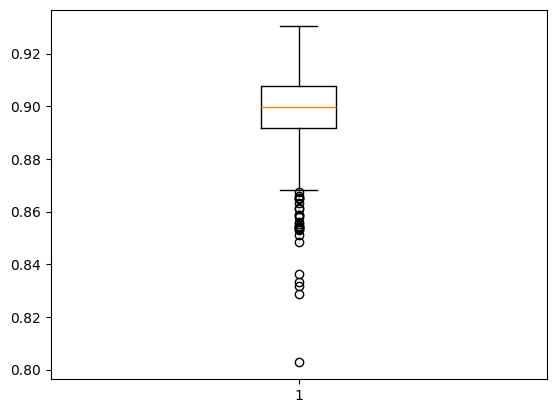

In [62]:
plt.boxplot([r[-1] for r in results[2]])

{'whiskers': [<matplotlib.lines.Line2D at 0x2229693f020>,
 'caps': [<matplotlib.lines.Line2D at 0x2229693f590>,
 'boxes': [<matplotlib.lines.Line2D at 0x22296920d40>],
 'medians': [<matplotlib.lines.Line2D at 0x2229693fad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2229693fe00>],
 'means': []}

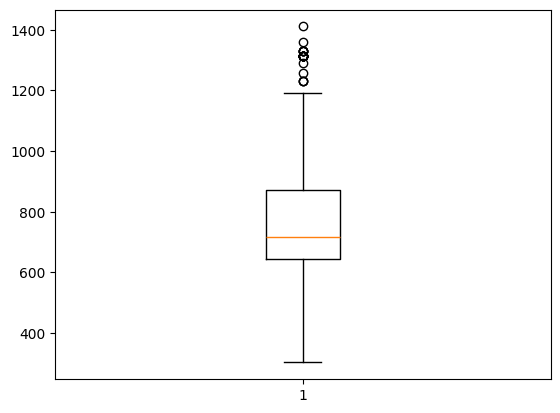

In [127]:
plt.boxplot([r[0] for r in results[0]])

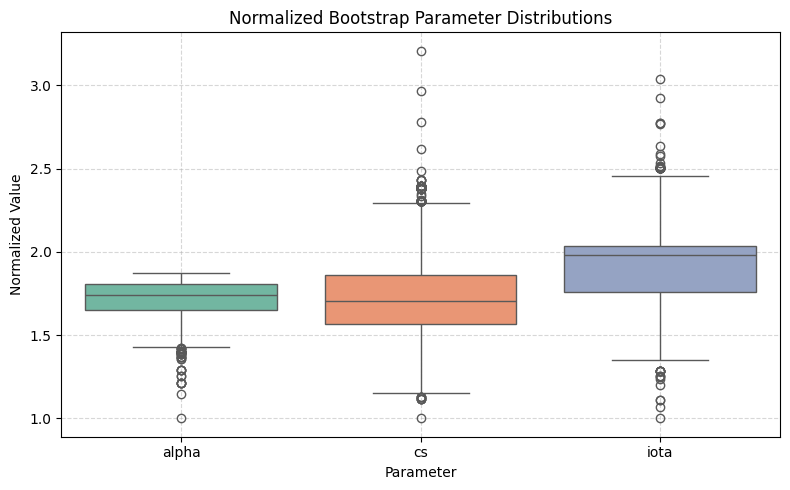

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Unpack the values from results[0]
alphas = [x[1] for x in results[0]]
css     = [x[0] for x in results[0]]
cms     = [x[4] for x in results[0]]
iotas   = [x[5] for x in results[0]]

# Create DataFrame
df_norm = pd.DataFrame({
    'alpha': [a/min(alphas) for a in alphas],
    'cs': [a/min(css) for a in css],
     #'cm': [a/min(cms) for a in cms],
    'iota': [a/min(iotas) for a in iotas]
})

df = pd.DataFrame({
    'alpha': alphas,
    'cs': css,
    'iota': iotas
})

# Normalize using Min-Max Scaling


# Convert to long format for seaborn
df_melted = df_norm.melt(var_name='Parameter', value_name='Normalized Value')

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x='Parameter', y='Normalized Value', hue='Parameter', palette="Set2")
plt.title('Normalized Bootstrap Parameter Distributions')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [59]:
# --- Compute statistics separately ---
means = df.mean()
stds = df.std()
iqrs = df.quantile(0.75) - df.quantile(0.25)
ranges = df.max() - df.min()
cv = stds / means

# --- Stability classification ---
cv_threshold = 0.3
stability = cv.apply(lambda x: 'unstable' if x > cv_threshold else 'stable')

# --- Combine into summary DataFrame ---
summary = pd.DataFrame({
    'mean': means,
    'std_dev': stds,
    'IQR': iqrs,
    'range': ranges,
    'cv': cv,
    'stability': stability
})

# --- Print summary ---
print("\n📊 Parameter Spread & Stability:\n")
print(summary.round(4))


📊 Parameter Spread & Stability:

           mean   std_dev       IQR      range      cv stability
alpha   14.1306    0.8799    0.7663     7.0071  0.0623    stable
cs     783.7037  196.6455  229.2317  1107.7639  0.2509    stable
cm       2.2182    0.7928    0.5867     3.9247  0.3574  unstable
iota    13.9399    2.2187    1.3841    12.2806  0.1592    stable


In [51]:
stds

alpha      0.381133
cs       153.810449
cm         0.510941
iota       2.379934
dtype: float64

In [25]:
data_path = r"data/catchments/GRDC-Daily.nc"
runoff = xr.open_mfdataset(data_path).load()
runoff = runoff.sel(time=slice('2000-03-01', '2022-12-19'))

def load_all_catchment_data(runoff, base_folder="data/catchment_timeseries"):
    all_data = {}

    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Match station name case-insensitively
        station_ids = runoff["station_name"].values
        match_index = [i for i, name in enumerate(station_ids) if name.lower() == folder_name.lower()]
        
        if not match_index:
            print(f"⚠️  No matching station found for folder: {folder_name}")
            continue

        station_index = match_index[0]

        try:
            temperature = xr.open_mfdataset(os.path.join(folder_path, 'temperature.nc'), combine='by_coords').load()
            precipitation = xr.open_mfdataset(os.path.join(folder_path, 'precipitation.nc'), combine='by_coords').load()
            radiation = xr.open_mfdataset(os.path.join(folder_path, 'radiation.nc'), combine='by_coords').load()
            ndvi = xr.open_mfdataset(os.path.join(folder_path, 'ndvi.nc'), combine='by_coords').load()

            runoff_ts = runoff["runoff_mean"].isel(id=station_index)

            ds = xr.Dataset()
            ds['temperature'] = temperature['t2m']
            ds['precipitation'] = precipitation['precipitation']
            ds['radiation'] = radiation['nr']
            ds['ndvi'] = ndvi['ndvi']
            ds['observed'] = runoff_ts.broadcast_like(ds['radiation'])

            # Clip time
            ds = ds.sel(time=slice('2000-03-01', '2022-12-19'))

            all_data[folder_name] = ds

        except Exception as e:
            print(f"❌ Error loading data for {folder_name}: {e}")

    return all_data

In [26]:
allData = load_all_catchment_data(runoff)

In [ ]:
results = run_parallel_ga_bootstrap(
    dataset=trainVal,  # Your xarray Dataset
    n_bootstraps=1000
)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

# To analyze results
all_best = results[0]

In [27]:

allParams = {}
allRs = {}
start_time = time.time()
for catchment, data in allData.items():
    print(catchment)
    trainVal, test = split_data(data, 0.8)
    results = run_parallel_ga_bootstrap(
    dataset=trainVal,  # Your xarray Dataset
    n_bootstraps=200
        )
        # To analyze results
    all_best = results[0]
    allParams[catchment] = all_best
    allRs[catchment] = results[2]
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

ACHSTETTEN


















Bootstrapping: 100%|██████████| 200/200 [00:07<00:00, 27.40it/s]



AttributeError: 'numpy.ndarray' object has no attribute 'sizes'